<a href="https://colab.research.google.com/github/katemcg/assignment3/blob/main/assignment3_Part2_3_hs3458_kem2231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center"><h1 align="center">QMSS5074GR <br> Projects in Advanced Machine Learning <br>Spring 2024 <br> FINAL PROJECT <br>Assignment 3 Part 2 [GROUP Assignment]</h1>

---
<br>

#### **Your Unis** : hs3458, kem2231
#### **Your Full names** : Harini Sundararajan, Kate McGrath
#### **Your AI Model Share Usernames**: harinisund, kem2231
#### **Link to your Public Github repository** : https://github.com/katemcg/assignment3
#### **Team member Contribution Percentages** : Fill here

The highest achievable marks are 120, with there being 20 extra credits. The overall distribution of marks is as follows:

Part 1:
EDA and basic ML models : [15 points]

Part 2:
Deep Learning Section: [60 Total possible]
Recurrent models : 20 points
3 other models (CNN and Transformers) : 22 points + 10 Extra credits
Results : 8 points


Github Section : [45 Total possible]
Inference pipeline : 25 Points + 10 Extra credits
Readme + Report : 10 points

Heavy weightage (45 total possible marks) is assigned to the last section. Please be mindful of the time required to complete the last section as it is non-trivial and the most important part of the final project. Read instructions on how to score Zero marks and how to score 45 marks on this.

## Stanford Sentiment Treebank - Movie Review Classification Competition


## **Instructions: [Total 85 Points for this part]**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data using keras Tokenizer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare

In [ ]:
# Get competition data
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/sst2_competition_data-repository:latest')

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

## IMPORTANT NOTE
This X_test has no relation to test_sample.csv
This X_test (downloaded from above link) is for prediction and submission to aimodelshare only. You can create a validation split from the X_train here or during instatiating the model.

The test_sample.csv is meant for only inference from your best 3 saved models, and is only meant to be used in the final front-end notebook (See last section, Note that it has a very high weightage in this assignment). Predicting the labels in correct format on this test_sample may also require you to change your preprocessing and transform code. Ensure you code it correctly and that your final front-end notebook can predict on it appropriately.

None of the training code in this notebook will go into your python files in Github or your front-end notebook (See last cell instructions)

In [4]:
# Set up X_train, X_test, and y_train_labels objects
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=Warning)

X_train=pd.read_csv("X_train.csv")
X_test=pd.read_csv("X_test.csv")
y_train_labels=pd.read_csv("y_train_labels.csv")

# Convert to series if your following preprocessor needs it
def to_series(df):
  if len(df.columns) == 1:
    return(df.squeeze())

X_train = to_series(X_train)
X_test = to_series(X_test)
y_train_labels = to_series(y_train_labels)

# One hot encode encode Y data here
y_train = pd.get_dummies(y_train_labels)

X_train.head()

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer/composer Bryan Adams contributes a slew...
3                 Yet the act is still charming here .
4    Whether or not you 're enlightened by any of D...
Name: text, dtype: object

##2.   Preprocess data using keras tokenizer / Write and Save Preprocessor function


In [5]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
# This preprocessor function makes use of the tf.keras tokenizer

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# [3 Pts]for this cell

# Build vocabulary from training text data

# preprocessor tokenizes words and makes sure all documents have the same length (perform padding with maxlen=40)

def preprocessor(texts, maxlen=40):
    """
    Preprocesses a list of texts using pre-defined functions to clean text and remove stopwords, tf.keras Tokenizer and pads sequences to a fixed length.

    Args:
    texts: List of strings representing input texts.
    maxlen: Maximum length of sequences after padding, set to 40.

    Returns:
    padded_sequences: Numpy array of padded sequences.
    tokenizer: Tokenizer object fitted on the input texts.
    """

    texts = texts.apply(clean_text)

    texts = texts.apply(remove_stopwords)

    # Initialize Tokenizer
    tokenizer = Tokenizer()

    # Fit tokenizer on input texts
    tokenizer.fit_on_texts(texts)

    # Convert texts to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to a fixed length
    padded_sequences = pad_sequences(sequences, maxlen)

    return padded_sequences, tokenizer

print(preprocessor(X_train)[0].shape)
print(preprocessor(X_test)[0].shape)

(6920, 40)
(1821, 40)


##3. Fit model on preprocessed data and save preprocessor function and model


In [9]:
from tensorflow.keras.layers import Dense, Embedding,Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

padded_sequences, tokenizer = preprocessor(X_train)

# A basic deep learning model (max 5 layers)  # [1 Pts]
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=40))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_path = "model_checkpoint.h5"

red_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
mod_check = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Fit the model with validation split
history = model.fit(padded_sequences, y_train,
                    batch_size=32, epochs=30, validation_split=0.2,
                    callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
172/173 [============================>.] - ETA: 0s - loss: 0.6749 - accuracy: 0.6068
Epoch 00001: val_accuracy improved from -inf to 0.14884, saving model to model_checkpoint.h5
173/173 [==============================] - 8s 38ms/step - loss: 0.6751 - accuracy: 0.6064 - val_loss: 0.8455 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.6537
Epoch 00002: val_accuracy improved from 0.14884 to 0.54986, saving model to model_checkpoint.h5
173/173 [==============================] - 6s 35ms/step - loss: 0.5819 - accuracy: 0.6537 - val_loss: 0.8475 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 3/30
172/173 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.9142
Epoch 00003: val_accuracy improved from 0.54986 to 0.63656, saving model to model_checkpoint.h5
173/173 [==============================] - 7s 39ms/step - loss: 0.2271 - accuracy: 0.9147 - val_loss: 0.9220 - val_accuracy: 0.6366 - lr:

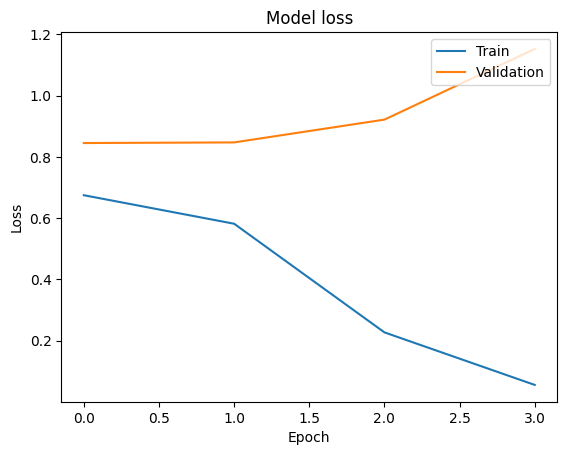

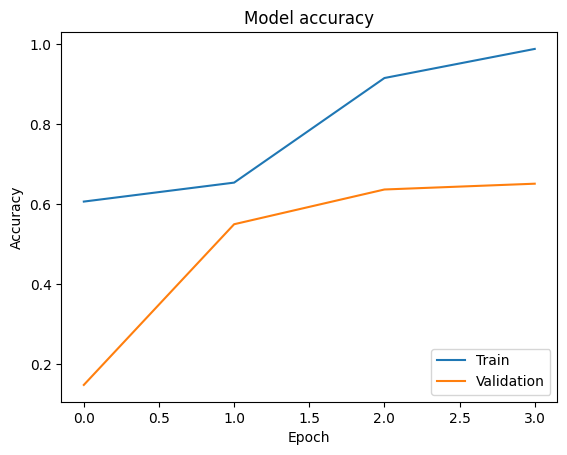

In [10]:
# Plot history [1 Pts]
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### Save preprocessor function to local "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"preprocessor.zip")

#### Save model to local ".onnx" file

In [11]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

apiurl="https://rlxjxnoql9.execute-api.us-east-1.amazonaws.com/prod/m" #This is the unique rest api that powers this specific Playground

set_credentials(apiurl=apiurl)

In [13]:
#Instantiate Competition

mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1:

# [1 Pts]

#-- Generate predicted y values on x_test (Model 1)
prediction_labels = model.predict(preprocessor(X_test)[0])

# extract correct prediction labels
model_filepath = "model.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model = "model.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

## 5. Repeat submission process to improve place on leaderboard


In [20]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten

# Code an model with atleast 3 LSTM layers (with Embedding Layer) # [1 Pts]
# Define the model architecture
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=40))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(16))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model with validation split
history2 = model2.fit(padded_sequences, y_train,
                      batch_size=32, epochs=30, validation_split=0.2,
                      callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6340
Epoch 00001: val_accuracy did not improve from 0.65101
173/173 [==============================] - 31s 118ms/step - loss: 0.6454 - accuracy: 0.6340 - val_loss: 0.7060 - val_accuracy: 0.5715 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8508
Epoch 00002: val_accuracy improved from 0.65101 to 0.69870, saving model to model_checkpoint.h5
173/173 [==============================] - 22s 126ms/step - loss: 0.3627 - accuracy: 0.8508 - val_loss: 0.6977 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9487
Epoch 00003: val_accuracy improved from 0.69870 to 0.72110, saving model to model_checkpoint.h5
173/173 [==============================] - 13s 77ms/step - loss: 0.1499 - accuracy: 0.9487 - val_loss: 0.8696 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 4/30
173/173 [=====

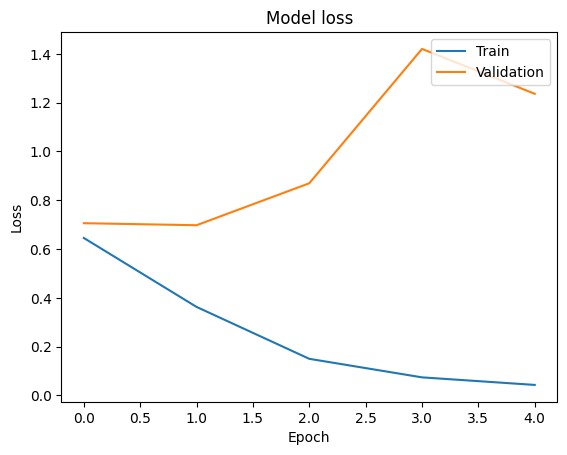

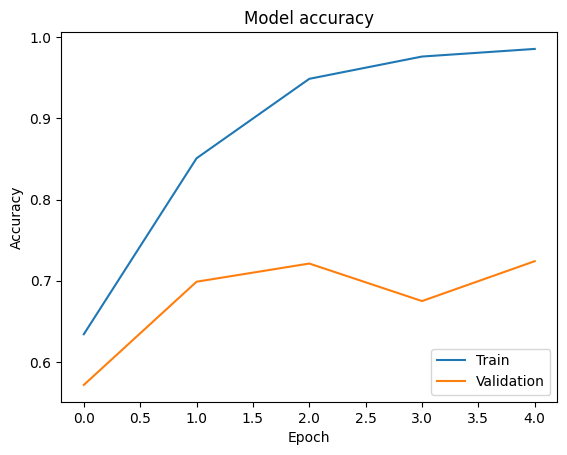

In [21]:
# Plot history [1 Pts]
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Does your model perform better or worse than your prior deep learning model? Why might that be the case?

In [ ]:
# Answer [1 Pts]

# this second model performs better, now with a validation accuracy of 0.72038
  # compared to 0.68786 for the first. so, the difference is only marginal, and
  # both models appear to be victims of overfitting, as the training accuracy
  # quickly reaches 1. still, some benefits of the second model using LSTM is
  # that it is intended to be used in situations where RNNs fail.

In [22]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model2, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 2:

#-- Generate predicted y values (Model 2)
prediction_labels = model.predict(preprocessor(X_test)[0])

# extract correct prediction labels
model_filepath = "model2.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model = "model2.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

## Tune model within range of hyperparameters with Keras Tuner


*Consult [documentation](https://keras.io/guides/keras_tuner/getting_started/) to see full functionality.*

In [ ]:
! pip install keras_tuner

In [ ]:
#Separate validation data here
from sklearn.model_selection import train_test_split
X_train_split, X_val, y_train_split, y_val = train_test_split(
     padded_sequences, y_train, test_size=0.2, random_state=42)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt

# Define model structure & parameter search space with a function
# code LSTM--based model with provision for searching hyperparameter space, return model  # [3 Pts]
# Define the model structure with hyperparameters

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=40))
    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Number of LSTM layers (1 to 3)
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=128, step=32), return_sequences=True))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout after each LSTM layer
    model.add(LSTM(16))  # Final LSTM layer
    model.add(Dropout(0.2))  # Dropout after the final LSTM layer
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#initialize the keras search tuner (which will search through parameters)   # [3 Pts]
# Define the following:
#Your function that returns the model
#objective to optimize
#max number of trials to run during search
#higher number reduces variance of results; guages model performance more accurately

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner feeding it the validation data
tuner.search(X_train_split, y_train_split,
             validation_data=(X_val, y_val), epochs=30,
             callbacks = [red_lr, mod_check, early_stop])

Trial 5 Complete [00h 02m 57s]
val_accuracy: 0.7528901696205139

Best val_accuracy So Far: 0.7666184902191162
Total elapsed time: 00h 13m 22s


In [ ]:
# [3 Pts]

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    tuned_model = build_model(hp)
    # Fit the model with the entire dataset
    tuned_model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6628
Epoch 00001: val_accuracy did not improve from 0.72110
173/173 [==============================] - 49s 233ms/step - loss: 0.6124 - accuracy: 0.6628 - val_loss: 0.6602 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.8895
Epoch 00002: val_accuracy did not improve from 0.72110
173/173 [==============================] - 24s 138ms/step - loss: 0.2785 - accuracy: 0.8895 - val_loss: 0.6484 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9626
Epoch 00003: val_accuracy did not improve from 0.72110
173/173 [==============================] - 24s 141ms/step - loss: 0.1019 - accuracy: 0.9626 - val_loss: 1.1386 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 4/30
173/173 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9857
Epoch 0000

What were the best hyperparameters found? Why might that be performing better than others?

In [ ]:
# Answer [2 Pts]
for hp in best_hps:
  print(hp.values)

# as seen below, the two models with the best hyperparams have some very similar
  # features, such as the 2 lstm layers, first dropout layer at 0.2, and the
  # second lstm layer with 32 units. of these two best models, the second performed
  # better, and it has additional hyperparams that may have allowed for this to
  # be the case.

{'num_lstm_layers': 2, 'lstm_0_units': 128, 'dropout_0': 0.2, 'lstm_1_units': 32, 'dropout_1': 0.2}
{'num_lstm_layers': 2, 'lstm_0_units': 32, 'dropout_0': 0.2, 'lstm_1_units': 32, 'dropout_1': 0.4, 'lstm_2_units': 96, 'dropout_2': 0.30000000000000004}


In [ ]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(tuned_model, framework='keras',
                           transfer_learning=False,
                           deep_learning=True)

with open("tuned_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 3:

#-- Generate predicted y values (Model 3)
prediction_labels = tuned_model.predict(preprocessor(X_test))

# extract correct prediction labels
model_filepath = "tuned_model.onnx"
preprocessor_filepath = "preprocessor.zip"

# Submit Model 3 to Competition Leaderboard
mycompetition.submit_model(model = "tuned_model.onnx",
                           preprocessor="preprocessor.zip",
                           prediction_submission=prediction_labels)

## 3 more models [30 Pts]

Train three more prediction models to try to predict the SST sentiment
dataset well.

○ Use Conv1d layers in first model [ 2 Pts]

○ Use Transfer learning with Glove Embeddings for 2nd model [10 Pts]

○ Third model can be any Transfer learning model of your choice (Transformer architecture required, eg. BERT and related) [10 Pts]

In [24]:
from sklearn.model_selection import train_test_split

padded_sequences, tokenizer = preprocessor(X_train)

X_train_split, X_val, y_train_split, y_val = train_test_split(
     padded_sequences, y_train, test_size=0.2, random_state=42)

from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "model_checkpoint.h5"

red_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
mod_check = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [25]:
# Model 1
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt

def build_model_conv1d(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=40))

    # Add Conv1D layers
    for i in range(hp.Int('num_conv1d_layers', 1, 3)):  # Number of Conv1D layers (1 to 3)
        model.add(Conv1D(filters=hp.Int(f'conv1d_{i}_filters', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Int(f'conv1d_{i}_kernel_size', min_value=3, max_value=5, step=2),
                         activation='relu'))
        model.add(GlobalMaxPooling1D())  # Apply global max pooling after each Conv1D layer

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer for regularization
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model_conv1d,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner
tuner.search(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=30, callbacks = [red_lr, mod_check, early_stop])

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    model = build_model_conv1d(hp)
    # Fit the model with the entire dataset
    model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

Trial 5 Complete [00h 01m 11s]
val_accuracy: 0.772398829460144

Best val_accuracy So Far: 0.772398829460144
Total elapsed time: 00h 04m 05s
Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6127
Epoch 00001: val_accuracy improved from -inf to 0.28613, saving model to model_checkpoint.h5
173/173 [==============================] - 19s 97ms/step - loss: 0.6550 - accuracy: 0.6127 - val_loss: 0.8406 - val_accuracy: 0.2861 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8497
Epoch 00002: val_accuracy improved from 0.28613 to 0.65462, saving model to model_checkpoint.h5
173/173 [==============================] - 13s 72ms/step - loss: 0.3562 - accuracy: 0.8497 - val_loss: 0.7814 - val_accuracy: 0.6546 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9796
Epoch 00003: val_accuracy improved from 0.65462 to 0.66980, saving model to model_checkpoin

In [ ]:
# saving model 1

model.save("model_conv.h5", save_format="h5")

In [26]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

--2024-05-01 03:13:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-01 03:13:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-01 03:13:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [27]:
# Model 2
from tensorflow.keras.initializers import Constant
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout
import keras_tuner as kt
from keras.optimizers import Adam

# Load pre-trained GloVe embeddings
embeddings_index = {}
embedding_dim = 100  # Assuming you want to use 100-dimensional GloVe embeddings
glove_file = 'glove.6B.100d.txt'  # Path to the GloVe embeddings file

with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model architecture
def build_model_glove(hp):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=40, trainable=False))  # Use pre-trained GloVe embeddings

    for i in range(hp.Int('num_lstm_layers', 1, 3)):  # Number of LSTM layers (1 to 3)
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=128, step=32),
                       return_sequences=True))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout after each LSTM layer

    model.add(LSTM(16))  # Final LSTM layer
    model.add(Dropout(0.2))  # Dropout after the final LSTM layer
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model_glove,
    objective='val_accuracy',
    max_trials=5
)

# Run the tuner
tuner.search(X_train_split, y_train_split,
             validation_data=(X_val, y_val), epochs=30,
             callbacks = [red_lr, mod_check, early_stop])

# Build model with best hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=2)  # Get the top 2 hyperparameters

# Iterate over the top hyperparameters
for hp in best_hps:
    # Build the model with the best hyperparameters
    model = build_model_glove(hp)
    # Fit the model with the entire dataset
    model.fit(padded_sequences, y_train, epochs=30, batch_size=32, callbacks = [red_lr, mod_check, early_stop], validation_split=0.2)

Reloading Tuner from ./untitled_project/tuner0.json
Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.6855
Epoch 00001: val_accuracy improved from 0.74711 to 0.77601, saving model to model_checkpoint.h5
173/173 [==============================] - 29s 105ms/step - loss: 0.5800 - accuracy: 0.6855 - val_loss: 0.5535 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 2/30
172/173 [============================>.] - ETA: 0s - loss: 0.4953 - accuracy: 0.7624
Epoch 00002: val_accuracy did not improve from 0.77601
173/173 [==============================] - 10s 57ms/step - loss: 0.4950 - accuracy: 0.7628 - val_loss: 0.5576 - val_accuracy: 0.7493 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.7758
Epoch 00003: val_accuracy improved from 0.77601 to 0.77890, saving model to model_checkpoint.h5
173/173 [==============================] - 18s 104ms/step - loss: 0.4636 - accuracy: 0.7758 - val_loss: 0.5170 - val_acc

In [ ]:
# saving model 2

model.save("model_glove.h5", save_format="h5")

We load the pre-trained GloVe embeddings and prepare an embedding matrix using the words in the tokenizer's vocabulary.
The Embedding layer of the model is initialized with the pre-trained GloVe embeddings using the Constant initializer, and we set trainable=False to freeze the embeddings during training.
The rest of the model architecture remains the same, and we use the Keras Tuner to search for the best hyperparameters while keeping the GloVe embeddings fixed.

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

In [7]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [8]:
# Model 3

# code based on https://www.tensorflow.org/text/tutorials/classify_text_with_bert

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(2, activation='softmax')(net)

    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(list(X_train[0:2])))

classifier_model.compile(optimizer = "adam",
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

history = classifier_model.fit(X_train, y_train,
                               validation_split=0.2, epochs=30,
                               callbacks = [red_lr, mod_check, early_stop])

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.5697
Epoch 00001: val_accuracy improved from -inf to 0.14884, saving model to model_checkpoint.h5
173/173 [==============================] - 276s 2s/step - loss: 0.7159 - accuracy: 0.5697 - val_loss: 1.2492 - val_accuracy: 0.1488 - lr: 0.0010
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.6794
Epoch 00002: val_accuracy improved from 0.14884 to 0.50506, saving model to model_checkpoint.h5
173/173 [==============================] - 238s 1s/step - loss: 0.6104 - accuracy: 0.6794 - val_loss: 1.1283 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.6432
Epoch 00003: val_accuracy did not improve from 0.50506
173/173 [==============================] - 253s 1s/step - loss: 0.6524 - accuracy: 0.6432 - val_loss: 0.7927 - val_accuracy: 0.1575 - lr: 0.0010
Epoch 4/30
173/173 [=============

In [10]:
# saving model 3

classifier_model.save("model_bert.h5", save_format="h5")

Tabularize results from ALL your models in this notebook and compare performance [5 Pts]

In [35]:
# copied from above epoch outputs

metrics_df = pd.DataFrame({
    'Model': ['mod1', 'mod2', 'tuner', 'conv','glove','bert'],
    'Accuracy': [0.65101, 0.72399, 0.75361, 0.74711, 0.80347, 0.84682],
    'Loss': [1.1529, 1.2366, 0.5703, 0.7456, 0.4863, 0.5296],
    })

print(metrics_df)

   Model  Accuracy    Loss
0   mod1   0.65101  1.1529
1   mod2   0.72399  1.2366
2  tuner   0.75361  0.5703
3   conv   0.74711  0.7456
4  glove   0.80347  0.4863
5   bert   0.84682  0.5296


Results Discussion : Point out why specific models may have performed better than others. and discuss failures if any. [3 Pts]

In [ ]:
# the table above shows a strong trend of accuracy improving as the model number
  # increased. this makes sense, because as we continued training, our models
  # became more comlpex, and, so, better able to understand and predict on the
  # data. alongside accuracy, loss also mostly improves by decreasing. our best
  # model was bert, but all the transfer models performed strongly.